In [1]:
# Load packages
suppressMessages(library(saqgetr))
suppressMessages(library(lubridate))
suppressMessages(library(tidyverse))
suppressMessages(library(openxlsx))
suppressMessages(library(plyr))

suppressMessages(library(openair))
suppressMessages(library(gridExtra))

In [2]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [3]:
# Working directory
setwd("~/Repositories/AirQualityCOVID")

load("data/data_AQ.rda")
load("data/meteorology.rda")

# Lockdown dates

In [4]:
periods <- list(
    # lockdown
    lockdown = ymd("2020-03-14"),
    #end.lockdown = as.numeric(ymd_hms("2020-04-28 00:00:00")),

    # poslockdown
    fases = ymd("2020-05-01"),
    normalidad = ymd("2020-06-21"),

    # New lockdown
    new.lockdown = ymd("2020-10-25")
)

## Load Data

In [5]:
aq <- data_AQ %>%
            filter(site == "es1580a",
                   variable == "no2") %>%
            timeAverage(avg.time = "day", type="variable")
aq$date <- as_date(aq$date)

mto <- data_Mto[data_Mto$site == "es1580a", ]

df <- merge(aq, mto,
              by = "date", all.x=T) %>%
        drop_na() %>%
        select(-date_end, -process, -summary, -validity, -site)

rm(data_AQ)
rm(data_Mto)

In [6]:
train <-  which(df$date < ymd("2020-01-01"))

In [7]:
df.data <- df %>%
        select(-date, -variable) %>% 
        scale() %>% data.frame()
time <- df$date

## Analysis

In [8]:
anly.data <- df.data

In [9]:
fit.th <- lm(value ~., data = anly.data, subset=train)

In [10]:
test <- which(df$date > ymd("2020-01-01"))
y.th <- predict(fit.th, newdata = anly.data[test,], 
                interval="confidence", level = 0.95)

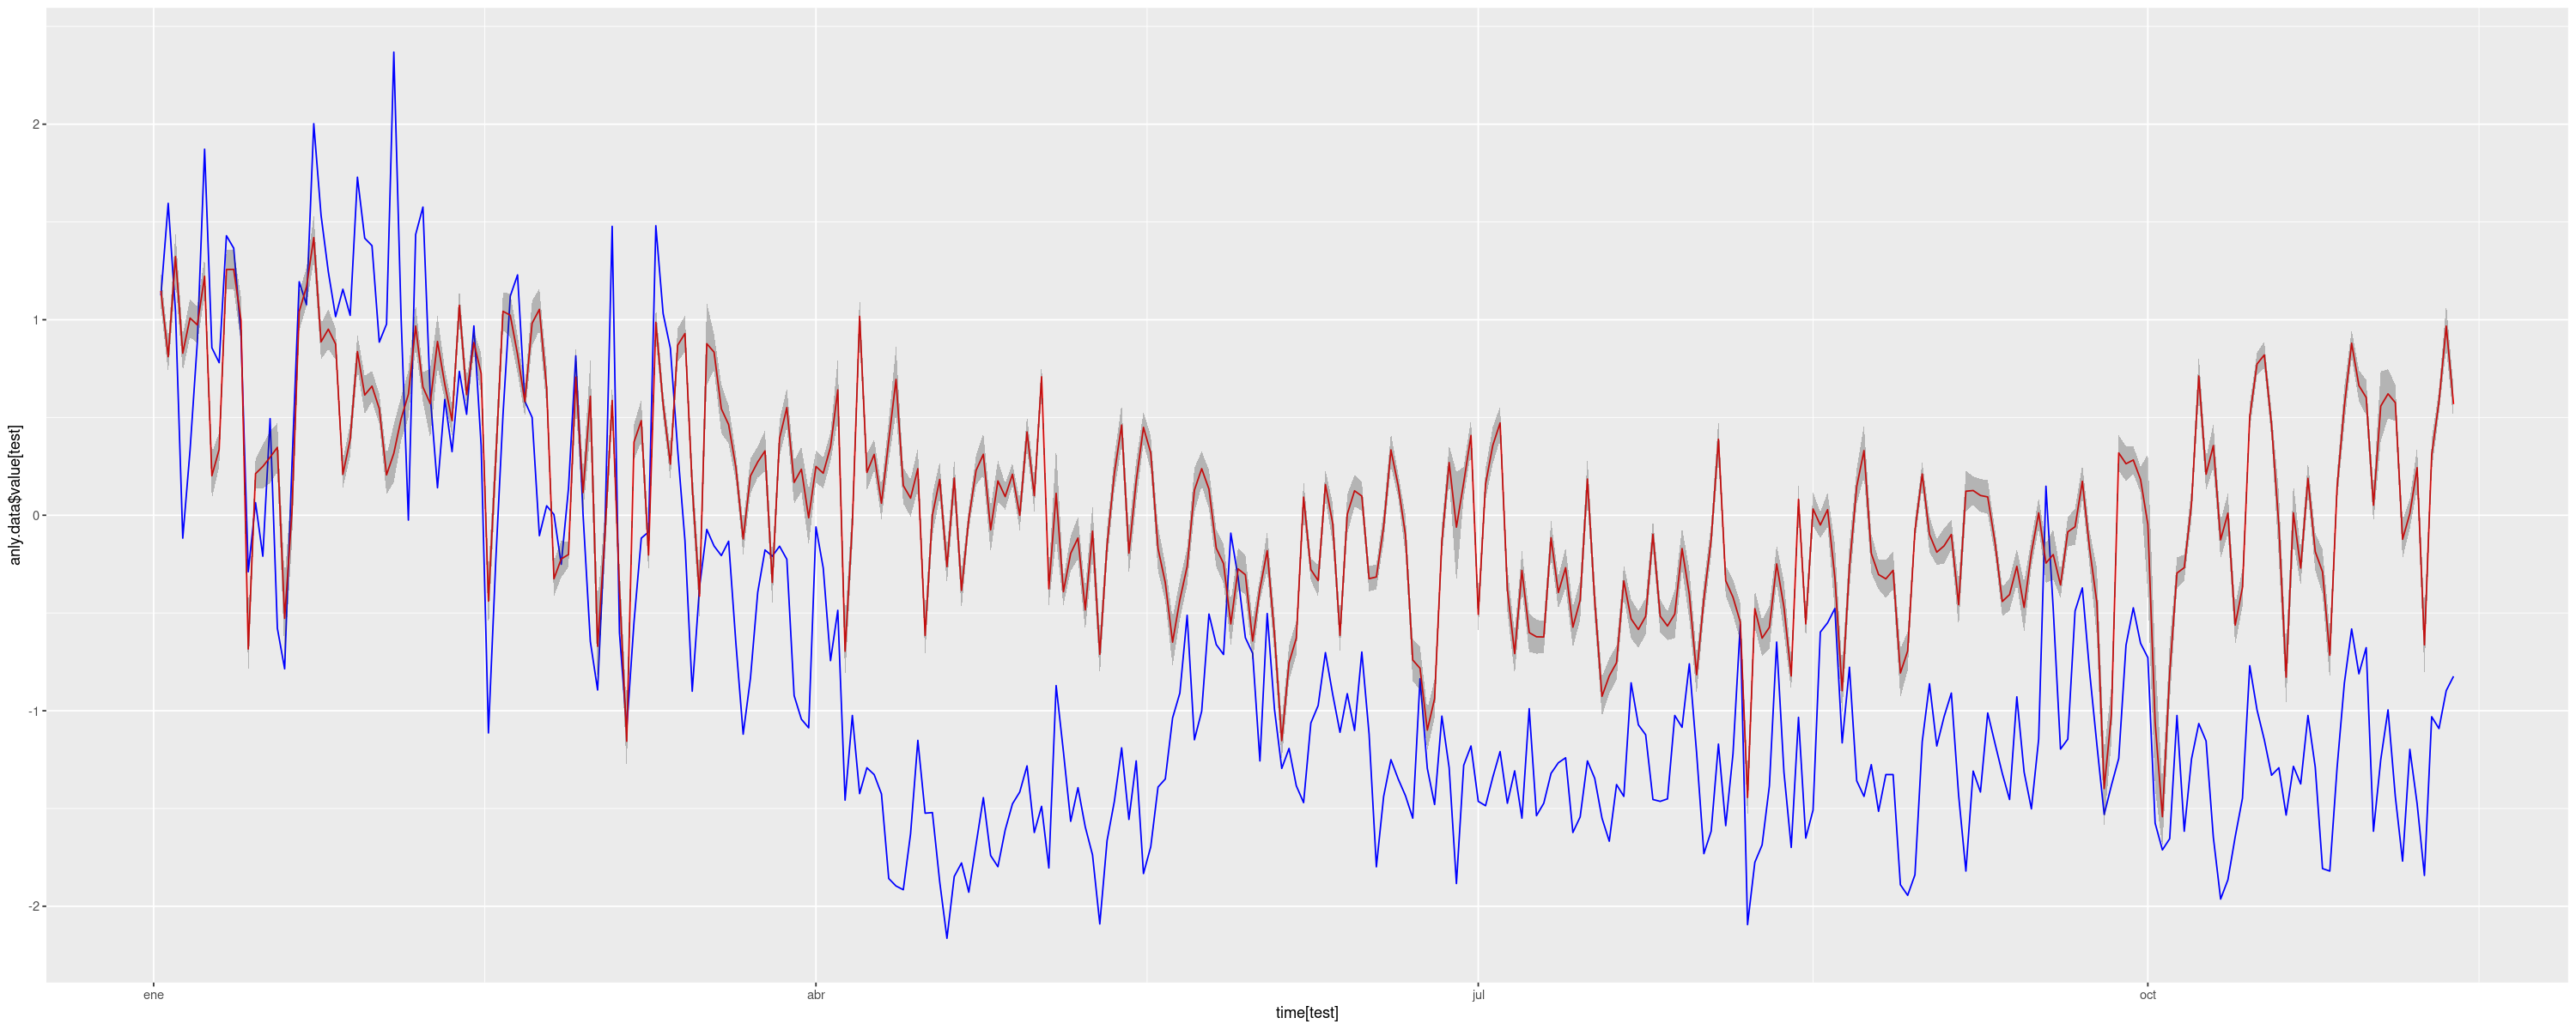

In [11]:
#all.series <- ggplot() +
#                geom_line(aes(x = time[train], y = anly.data$value[train]), color="blue") +
#                geom_line(aes(x = time[train], y = fit.th$fitted.values), color="red")
last.series <- ggplot() +
                geom_line(aes(x = time[test], y = anly.data$value[test]), color="blue") +
                geom_line(aes(x = time[test], y = y.th[,1]), color="red") +
                  geom_ribbon(aes(x = time[test], 
                                  ymin=y.th[,2], ymax=y.th[,3]),
                              alpha=0.3)
last.series
#grid.arrange(all.series, last.series, nrow = 1, widths = c(2, 1))

## Validation

cor(fit.th$fitted.values, anly.data$value[train])

mean(fit.th$fitted.values - anly.data$value[train])

mean((fit.th$fitted.values - anly.data$value[train])^2)

var.test(fit.th$fitted.values, anly.data$value[train])

## Using `segmented` package

In [27]:
suppressMessages(library(segmented))

var <- data.frame(y = (anly.data$value[test] - y.th[, 1] ),
                  x = as.numeric(time[test]))

my.seg.1 <- segmented(lm(y ~ x, data=var), 
                      seg.Z = ~ x,
                      psi = unlist(periods)
                     )

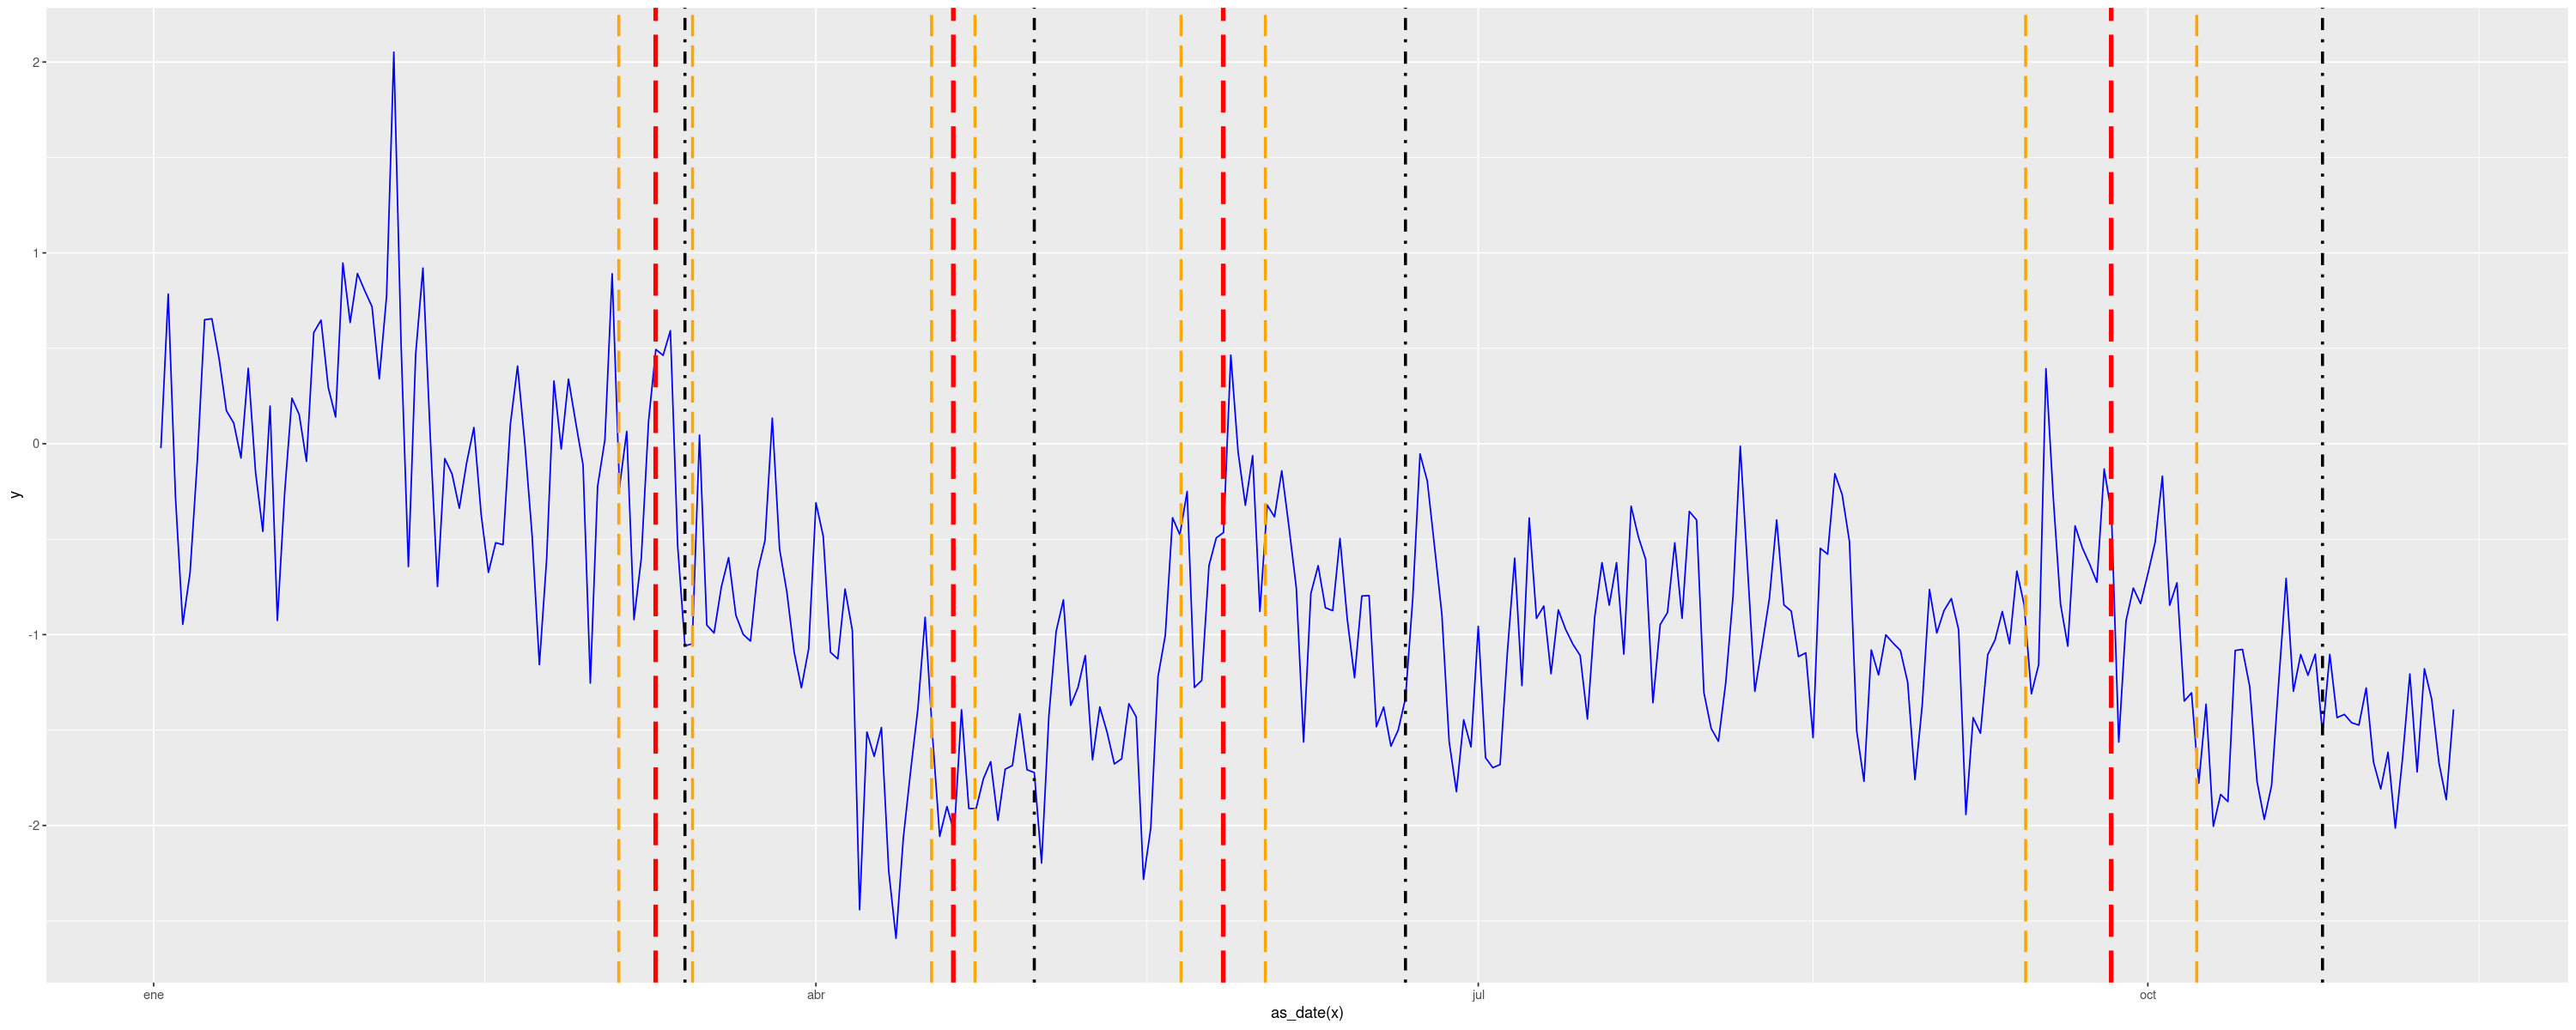

In [58]:
plot <- ggplot(data=var, aes(x=as_date(x)))+ 
    geom_line(aes(y=y), color="blue", size=0.5)

if (length(my.seg.1$psi) != 0) {
    for (k in 1:(nrow(my.seg.1$psi))) {
        plot <- plot + geom_vline(xintercept = my.seg.1$psi[k,"Est."], 
                                  linetype=5, color = "red", size=1.5)
        plot <- plot + geom_vline(xintercept = my.seg.1$psi[k,"Est."] - my.seg.1$psi[k,"St.Err"], 
                                  linetype=5, color = "orange", size=1)
        plot <- plot + geom_vline(xintercept = my.seg.1$psi[k,"Est."] + my.seg.1$psi[k,"St.Err"], 
                                  linetype=5, color = "orange", size=1)
    }
}

for (k in 1:(length(periods))) {
    plot <- plot + geom_vline(xintercept = as.numeric(periods[k]), 
                              linetype=4, color = "black", size=1)
}

plot

In [29]:
as_date(my.seg.1$psi[, "Est."])
as_date(my.seg.1$psi[, "Initial"])

psi1.x       psi2.x       psi3.x       psi4.x 
"2020-03-09" "2020-04-19" "2020-05-26" "2020-09-25"

psi1.x       psi2.x       psi3.x       psi4.x 
"2020-03-14" "2020-05-01" "2020-06-21" "2020-10-25"

## Using `strucchange` package

In [49]:
suppressMessages(library(strucchange))

my.other.seg.1 <- breakpoints(y ~ x+1,
                              h = 45, 
                              breaks = 4,
                              data = var)
new.breaks.1 <- as_datetime(my.other.seg.1$breakpoints)

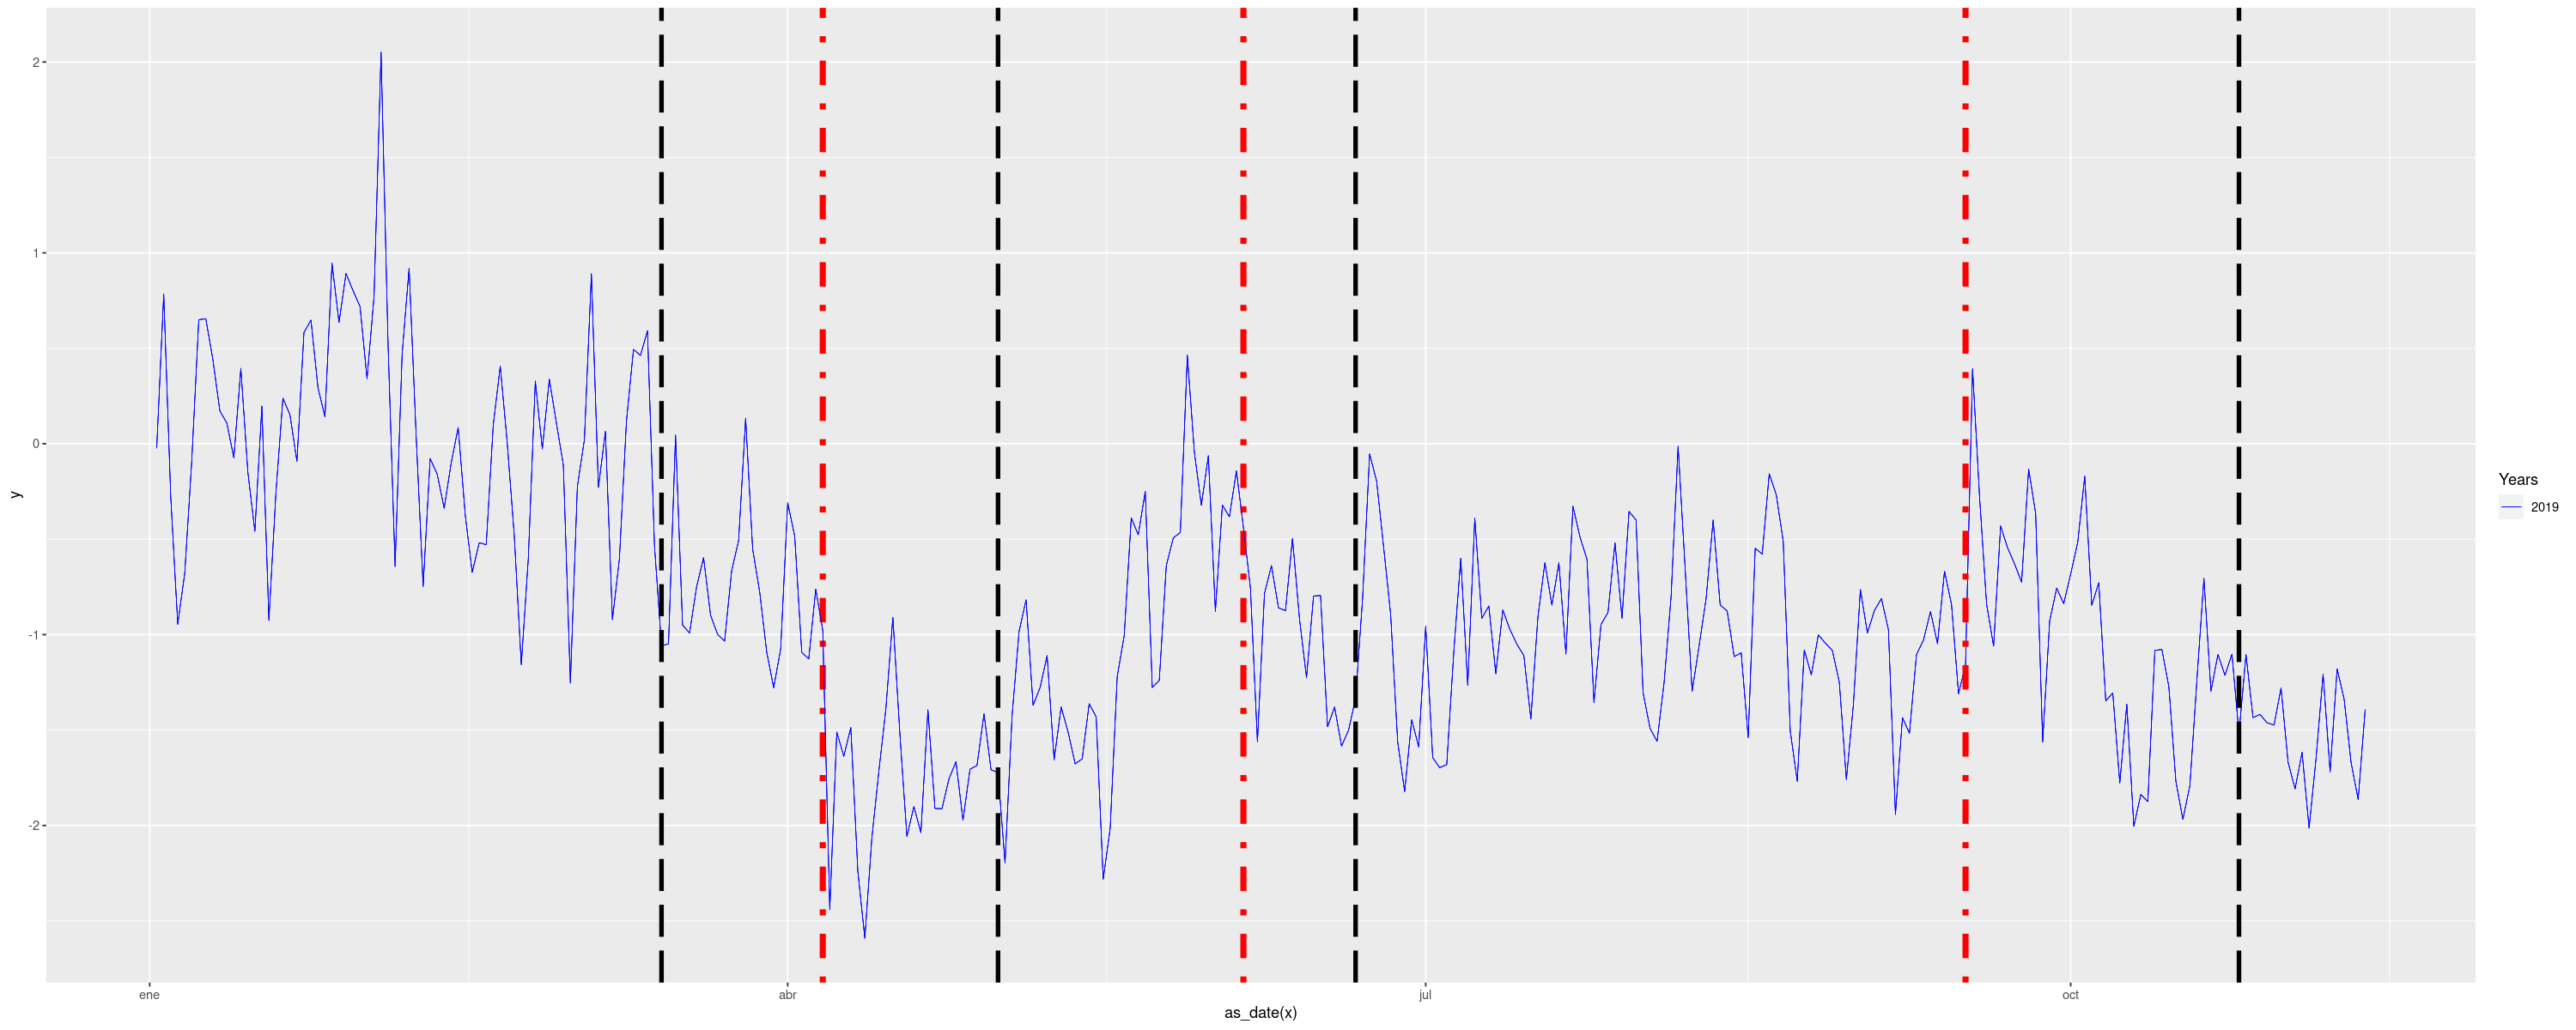

In [54]:
plot <- ggplot(data=var, aes(x=as_date(x))) + 
        scale_color_manual(name = "Years", values = c("2019" = "blue"))
for (k in 1:(length(new.breaks.1))) {
    plot <- plot + geom_line(aes(y=y, color="2019"), size=0.2)
    plot <- plot + geom_vline(xintercept = var$x[new.breaks.1[k]], 
                              linetype=4, color = "red", size=2)
}

for (k in 1:(length(periods))) {
    plot <- plot + geom_vline(xintercept = as.numeric(periods[k]), 
                              linetype=5, color = "black", size=1.5)
}

plot 

In [17]:
time[-train][new.breaks.1]

[1] "2020-04-05" "2020-06-04" "2020-09-15"

## Relative Change

In [45]:
data.prd.raw <- list()
data.prd.model <- list()

new.periods <- c(as.numeric(ymd("2020-01-01")), periods, as.numeric(max(time)))

for (i in 2:length(new.periods)) {
    data.prd.raw[[names(periods)[i-1]]] <- mean(anly.data$value[which(time < new.periods[i] &
                                                       time > new.periods[i-1])])
    data.prd.model[[names(periods)[i-1]]] <- mean(y.th[which(time[test] < new.periods[i] &
                                                       time[test] > new.periods[i-1]), 1])
}

In [46]:
names(data.prd.model)[5] <- "end.year"
names(data.prd.raw)[5] <- "end.year"

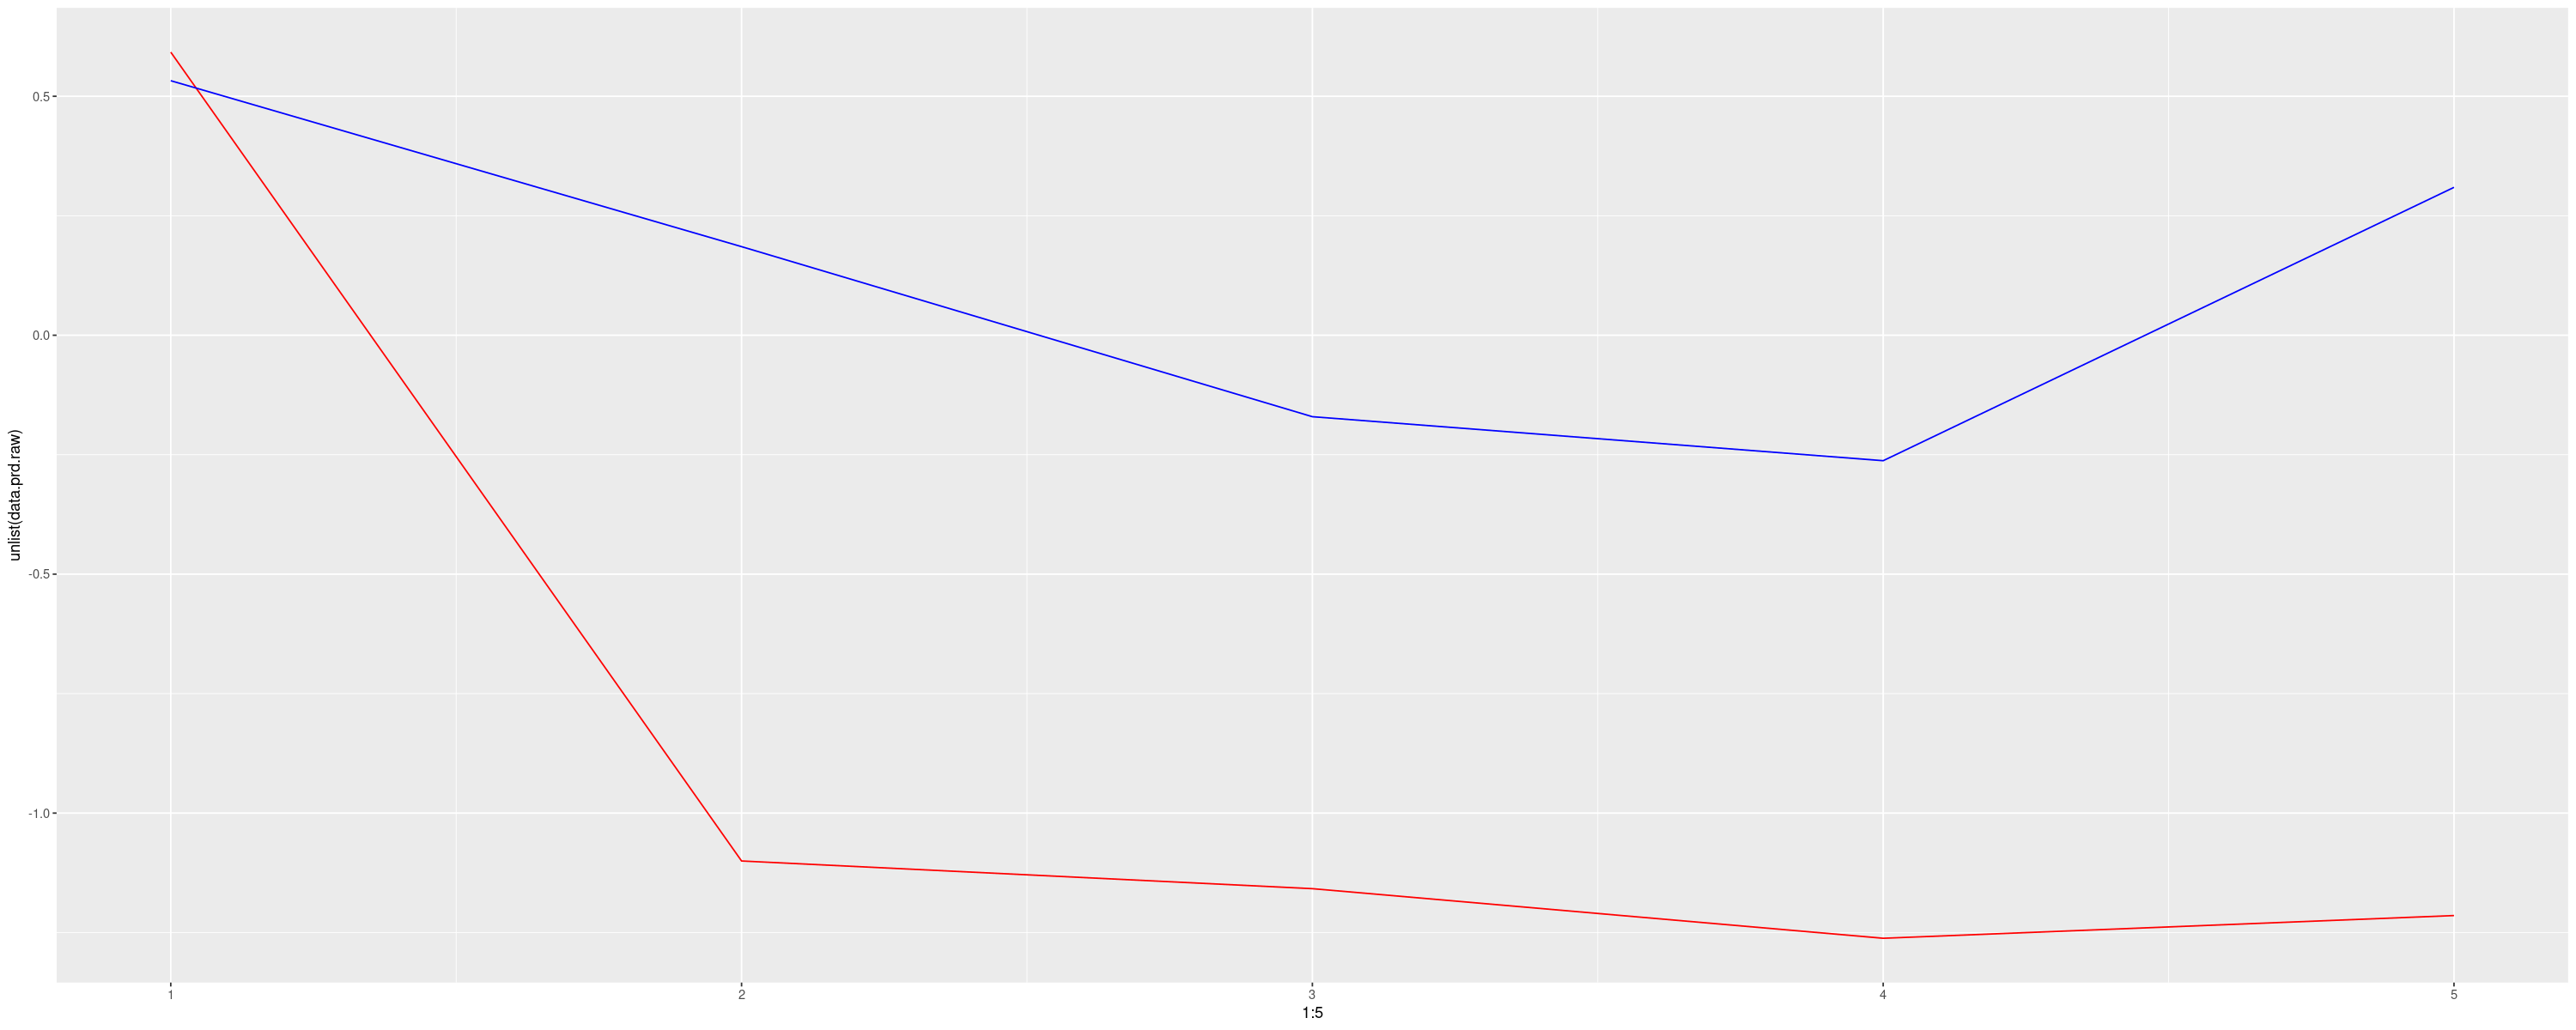

In [47]:
ggplot() +
    geom_line(aes(x=1:5, y=unlist(data.prd.raw)), color="red") +
    geom_line(aes(x=1:5, y=unlist(data.prd.model)), color="blue")

In [48]:
change <- list()

for (nm in names(data.prd.model)) {
    x <- unlist(data.prd.raw)
    y <- unlist(data.prd.model)
    #f.x.y <- min(c(abs(y)))
    f.x.y <- abs(data.prd.model[[nm]])
    change[[nm]] <- ((data.prd.raw[[nm]] - data.prd.model[[nm]]) 
                     / data.prd.model[[nm]])
}

change

$lockdown
[1] 0.1122813

$fases
[1] -6.936473

$normalidad
[1] 5.792164

$new.lockdown
[1] 3.806293

$end.year
[1] -4.924243